# <font color='purple'> **Práctica 2. Sensando y análisis de video.** </font>

**Elaborado por:** Scarlett Magdaleno Gatica. 

El propósito de este notebook es recolectar videos de personas simulando la acción de conducir, con el objetivo de desarrollar un clasificador capaz de distinguir entre cinco puntos de atención visual diferentes.


### <font color='purple'> **Dataset** </font>

El dataset se creó a partir de la grabación de videos de conductores que alternaban su vista a cinco puntos de atención visual (PAV): (i) frente; retrovisores (ii) central, (iii) izquierdo y (iv) derecho; (v) palanca. 

Cada video del dataset está etiquetado en un archivo csv de la siguiente forma:

    nombre del archivo, inicio del PAV, fin del PAV, PAV (e.g. video.mp4, 0:05, 0:15, frente)
    
Los videos utilizados en este notebook fueron los siguientes:

    ANDRES.mp4
    ARIANA.mp4
    DAFNE.mp4
    JESUS.mp4
    RACHEL.mp4
    SCARLETT.mp4
    
**Notas importantes:** 
+ Los archivos .csv utilizados se ubican en la carpeta *Imagen* dentro de este repositorio. Sin embargo, los videos no están incluidos en el repositorio debido a consideraciones de privacidad de los participantes. 
+ Para evaluar el clasificador en tiempo real, por favor, ejecute la celda "Importar librerías", descargue los archivos "df_all_selected.csv" y "df_filter_selected.csv" disponibles en este repositorio y continúe ejecutando la sección 6 del notebook. 
+ El video utilizado en la sección 6.2 no se incluye en el notebook por razones de privacidad. No obstante, puede reemplazar el nombre del archivo "MARCOS.mp4" con el nombre del video que desee evaluar y se encuentre en su repositorio local.

### <font color='purple'> **Importamos las librerías** </font>

In [1]:
# system libraries
import os
import sys
import re

# data 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# video
import mediapipe as mp
import cv2
from IPython.display import Video

# files
from scipy.io.wavfile import write
import shutil

# feature selection
from sklearn.feature_selection import mutual_info_classif

# data partitioning
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# model construction
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.validation import check_array
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <font color='purple'> **1.- Segmentación de los videos** </font>

En esta sección, procederemos a leer cada archivo de video en la carpeta *Imagen*, junto con su correspondiente archivo CSV, para luego segmentarlos por clases en subcarpetas dentro de la nueva carpeta *VideosSegmentados*.

In [2]:
def segmentar_video(video_filename, marca_tiempo_inicio, marca_tiempo_fin, output_folder, etiqueta, video_number):
   
    cap = cv2.VideoCapture(video_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Manejar el caso en que fps sea cero
    if fps == 0:
        print("¡Error! El FPS del video es cero.")
        return
    
    # Convertir las marcas de tiempo de formato 'mm:ss' a segundos
    inicio_segundos = sum(x * int(t) for x, t in zip([60, 1], marca_tiempo_inicio.split(':')))
    fin_segundos = sum(x * int(t) for x, t in zip([60, 1], marca_tiempo_fin.split(':')))
    
    cap.set(cv2.CAP_PROP_POS_MSEC, inicio_segundos * 1000)
    
    # Nombre del archivo de salida
    output_filename = os.path.join(output_folder, os.path.basename(video_filename))
    output_filename = os.path.splitext(output_filename)[0] + '_' + str(etiqueta) + '_' + str(video_number) + '.mp4'
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (int(cap.get(3)), int(cap.get(4))))
    
    frame_count = 0  # Contador de fotogramas escritos en el archivo de salida
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True and cap.get(cv2.CAP_PROP_POS_MSEC) / 1000 < fin_segundos:
            out.write(frame)
            frame_count += 1
        else:
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()


# Directorio del notebook
notebook_directory = os.getcwd()

# Directorio de la carpeta imagen (considerando que está en el mismo nivel que el notebook)
main_folder = os.path.join(notebook_directory, "Imagen")

# Directorio de salida para los videos segmentados
output_folder_base = os.path.join(notebook_directory, "VideosSegmentados")

# Diccionario para almacenar los contadores de video por etiqueta
contador_videos_por_etiqueta = {"central": 0, "izquierdo": 0, "derecho": 0, "frente": 0, "palanca": 0}

for subdir, dirs, files in os.walk(main_folder):
    for file in files:
        if file.endswith('.csv'):
            csv_path = os.path.join(subdir, file)
            data = pd.read_csv(csv_path)
            # Crear una carpeta para cada etiqueta
            labels = data['label'].unique()
            for label in labels:
                label_folder = os.path.join(output_folder_base, label)
                os.makedirs(label_folder, exist_ok=True)
                # Iterar sobre cada fila del archivo CSV y segmentar el video correspondiente
                for index, row in data[data['label'] == label].iterrows():
                    video_filename = os.path.join(subdir, os.path.splitext(row['filename'])[0] + '.mp4')  
                    marca_tiempo_inicio = row['inicio']
                    marca_tiempo_fin = row['fin']
                    output_folder = label_folder
                    etiqueta_actual = row['label']

                    # Incrementar el contador de videos para esta etiqueta
                    contador_videos_por_etiqueta[etiqueta_actual] += 1
                    video_number = contador_videos_por_etiqueta[etiqueta_actual]                  
                    
                    segmentar_video(video_filename, marca_tiempo_inicio, marca_tiempo_fin, output_folder, etiqueta_actual, video_number)


**Observación:** Se realizaron análisis de los videos segmentados y se corrigieron algunas de las etiquetas donde el video correspondía a la clase "derecho" pero se encontraba etiquetado como "izquierdo", y viceversa. Además, se observaron instancias en las que, aunque coinciden con los datos etiquetados, el conductor dirige su atención visual a más de un punto durante el video. Esta situación podría plantear un desafío para el entrenamiento del modelo, ya que podría generar confusión entre las clases.

Se ha tomado la decisión de utilizar dos conjuntos de datos: uno que incluye todos los videos y otro que excluye estas instancias, con el fin de evaluar el impacto en los modelos.

Para esto, crearemos una segunda carpeta llamada "VideosSegmentados2" la cual excluye estas instancias. 

In [5]:
# Crear la nueva carpeta VideosSegmentados2 si no existe
if not os.path.exists('VideosSegmentados2'):
    os.mkdir('VideosSegmentados2')

# Definir el directorio de origen y destino
videos_segmentados_dir = 'VideosSegmentados'
videos_segmentados2_dir = 'VideosSegmentados2'

# Instancias que podrían generar confusión
pattern = re.compile(r'.*(ANDRES|DAFNE).*\.mp4', re.IGNORECASE)

# Recorrer recursivamente todas las subcarpetas y archivos en el directorio de origen
for root, dirs, files in os.walk(videos_segmentados_dir):
    # Iterar sobre las carpetas
    for dir in dirs:
        src_dir = os.path.join(root, dir)
        dst_dir = os.path.join(videos_segmentados2_dir, os.path.relpath(src_dir, videos_segmentados_dir))
        # Crear el directorio de destino si no existe
        os.makedirs(dst_dir, exist_ok=True)
    # Iterar sobre los archivos en el directorio actual
    for file in files:
        # Comprobar si el nombre del archivo no cumple con el patrón
        if not pattern.match(file):
            # Ruta de origen y destino del archivo
            src = os.path.join(root, file)
            dst = os.path.join(videos_segmentados2_dir, os.path.relpath(src, videos_segmentados_dir))
            # Copiar el archivo
            shutil.copy2(src, dst)

## <font color='purple'> **2.- Extracción de características** </font>

En esta sección, extraeremos los landmarks de cada video segmentado.

### <font color='purple'> **2.1 Definición de función para extracción de landmarks** </font>

Definimos la función para extracción de landmarks con face mesh.

In [2]:
# Función para extraer landmarks faciales de un fotograma
def extract_landmarks(frame):
    mp_face_mesh = mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5)
    
    with mp_face_mesh as face_mesh:
        # Convertir la imagen a RGB
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Procesar la imagen y obtener los resultados de los landmarks faciales
        results = face_mesh.process(image_rgb)
        
        # Verificar si se detectaron landmarks faciales
        if results.multi_face_landmarks:
            # Obtener los landmarks faciales del primer rostro detectado (asumiendo un solo rostro)
            face_landmarks = results.multi_face_landmarks[0]
            
            # Convertir los landmarks a una lista de tuplas de coordenadas (x, y, z)
            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            
            return landmarks  # Devolver la lista de landmarks faciales
    return None


### <font color='purple'> **2.2 Dataset completo** </font>

Extraemos los landmarks del dataset completo.

In [15]:
# Carpeta que contiene las subcarpetas con los videos
videos_folder = 'VideosSegmentados'

# Inicializar un DataFrame para almacenar los landmarks faciales de todos los videos
df_all_data_landmarks = pd.DataFrame(columns=['Video', 'Frame', 'Landmarks'])

landmarks_data = pd.DataFrame(columns=['filename'] + [f"x_{i}" for i in range(468)] + [f"y_{i}" for i in range(468)] + [f"z_{i}" for i in range(468)] + ['label'])

# Iterar sobre el árbol de directorios de la carpeta "VideosSegmentados"
for root, dirs, files in os.walk(videos_folder):
    # Iterar sobre los archivos de video en el directorio actual
    for file in files:
        video_path = os.path.join(root, file)
        # Verificar si el archivo es un video basándose en su extensión
        if os.path.isfile(video_path) and file.lower().endswith('.mp4'):
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error al abrir el video: {file}")
                continue
            
            # Establecer la tasa de fotogramas deseada
            cap.set(cv2.CAP_PROP_FPS, 20)

            while True:
                success, frame = cap.read()
                if not success:
                    # Indica el fin del video y sale del bucle
                    break

                # Extraer landmarks faciales del fotograma actual
                landmarks = extract_landmarks(frame)

                # Almacenar los landmarks en el DataFrame junto con el nombre del video y el número de fotograma
                df_all_data_landmarks = df_all_data_landmarks.append({'Video': file, 'Frame': cap.get(cv2.CAP_PROP_POS_FRAMES), 'Landmarks': landmarks}, ignore_index=True)

                if landmarks:
                    # Crear un diccionario para almacenar las coordenadas de cada landmark
                    landmark_dict = {"filename": file}
                    for i, lm in enumerate(landmarks):
                        landmark_dict[f"x_{i}"] = lm[0]
                        landmark_dict[f"y_{i}"] = lm[1]
                        landmark_dict[f"z_{i}"] = lm[2]
                    # Agregar la etiqueta al diccionario
                    label = file.split('_')[1]  # Extraer la etiqueta del nombre de archivo
                    landmark_dict['label'] = label
                    # Agregar el diccionario al DataFrame
                    landmarks_data = landmarks_data.append(landmark_dict, ignore_index=True)

            # Liberar los recursos del video actual
            cap.release()


In [16]:
landmarks_data

,filename,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,z_459,z_460,z_461,z_462,z_463,z_464,z_465,z_466,z_467,label
0,ANDRES_central_1.mp4,0.423618,0.418933,0.424612,0.412191,0.418408,0.420229,0.427040,0.349046,0.428508,...,-0.060105,-0.034010,-0.063050,-0.047970,0.005975,0.000166,-0.008473,0.000663,-0.000427,central
1,ANDRES_central_1.mp4,0.415535,0.409061,0.416111,0.403401,0.408456,0.410786,0.419194,0.342385,0.421319,...,-0.060644,-0.035067,-0.063349,-0.048298,0.005689,0.000167,-0.008289,-0.001316,-0.002603,central
2,ANDRES_central_1.mp4,0.405310,0.397977,0.406081,0.393621,0.397450,0.400282,0.410195,0.335502,0.412869,...,-0.060726,-0.035421,-0.063000,-0.047963,0.002883,-0.002311,-0.010423,-0.006159,-0.007528,central
3,ANDRES_central_1.mp4,0.393906,0.385074,0.394976,0.381659,0.384308,0.387550,0.399104,0.327728,0.402049,...,-0.061844,-0.037312,-0.063675,-0.048738,0.002167,-0.002510,-0.010395,-0.009737,-0.011471,central
4,ANDRES_central_1.mp4,0.388235,0.378933,0.389493,0.376515,0.378164,0.381696,0.394214,0.325826,0.397569,...,-0.061274,-0.037536,-0.062708,-0.048052,0.001094,-0.003275,-0.010765,-0.012519,-0.014485,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9057,SCARLETT_palanca_7.mp4,0.286524,0.251284,0.280877,0.248302,0.247683,0.253657,0.279277,0.184214,0.285353,...,-0.094347,-0.050190,-0.090507,-0.063461,-0.052396,-0.055089,-0.063383,-0.087404,-0.092134,palanca
9058,SCARLETT_palanca_7.mp4,0.285739,0.250373,0.280047,0.247461,0.246779,0.252779,0.278517,0.183397,0.284635,...,-0.094476,-0.050256,-0.090624,-0.063532,-0.052499,-0.055196,-0.063500,-0.087579,-0.092347,palanca
9059,SCARLETT_palanca_7.mp4,0.285299,0.249964,0.279628,0.247088,0.246354,0.252393,0.278341,0.183189,0.284543,...,-0.094838,-0.050387,-0.090921,-0.063710,-0.053149,-0.055815,-0.064088,-0.088358,-0.093105,palanca
9060,SCARLETT_palanca_7.mp4,0.284565,0.249539,0.279140,0.246836,0.245977,0.252092,0.278176,0.183076,0.284439,...,-0.094829,-0.050369,-0.090912,-0.063689,-0.053108,-0.055769,-0.064049,-0.088389,-0.093171,palanca


In [17]:
df_all_data_landmarks = landmarks_data
# Guardar el DataFrame con los landmarks de todos los videos como un archivo CSV
df_all_data_landmarks.to_csv('df_all_data_landmarks.csv', index=False)

### <font color='purple'> **2.2 Dataset filtrado** </font>

Extraemos los landmarks del dataset filtrado.

In [18]:
# Carpeta que contiene las subcarpetas con los videos
videos_folder = 'VideosSegmentados2'

# Inicializar un DataFrame para almacenar los landmarks faciales de todos los videos
df_filter_data_landmarks = pd.DataFrame(columns=['Video', 'Frame', 'Landmarks'])

landmarks_filter_data = pd.DataFrame(columns=['filename'] + [f"x_{i}" for i in range(468)] + [f"y_{i}" for i in range(468)] + [f"z_{i}" for i in range(468)] + ['label'])

# Iterar sobre el árbol de directorios de la carpeta "VideosSegmentados2"
for root, dirs, files in os.walk(videos_folder):
    # Iterar sobre los archivos de video en el directorio actual
    for file in files:
        video_path = os.path.join(root, file)
        # Verificar si el archivo es un video basándose en su extensión
        if os.path.isfile(video_path) and file.lower().endswith('.mp4'):
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error al abrir el video: {file}")
                continue
            
            # Establecer la tasa de fotogramas deseada
            cap.set(cv2.CAP_PROP_FPS, 20)

            while True:
                success, frame = cap.read()
                if not success:
                    # Indica el fin del video y sale del bucle
                    break

                # Extraer landmarks faciales del fotograma actual
                landmarks = extract_landmarks(frame)

                # Almacenar los landmarks en el DataFrame junto con el nombre del video y el número de fotograma
                df_filter_data_landmarks = df_filter_data_landmarks.append({'Video': file, 'Frame': cap.get(cv2.CAP_PROP_POS_FRAMES), 'Landmarks': landmarks}, ignore_index=True)

                if landmarks:
                    # Crear un diccionario para almacenar las coordenadas de cada landmark
                    landmark_dict = {"filename": file}
                    for i, lm in enumerate(landmarks):
                        landmark_dict[f"x_{i}"] = lm[0]
                        landmark_dict[f"y_{i}"] = lm[1]
                        landmark_dict[f"z_{i}"] = lm[2]
                    # Agregar la etiqueta al diccionario
                    label = file.split('_')[1]  # Extraer la etiqueta del nombre de archivo
                    landmark_dict['label'] = label
                    # Agregar el diccionario al DataFrame
                    landmarks_filter_data = landmarks_filter_data.append(landmark_dict, ignore_index=True)

            # Liberar los recursos del video actual
            cap.release()

In [19]:
landmarks_filter_data

,filename,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,z_459,z_460,z_461,z_462,z_463,z_464,z_465,z_466,z_467,label
0,ARIANA_central_3.mp4,0.374296,0.354099,0.380885,0.370500,0.353905,0.364283,0.398759,0.376263,0.409414,...,-0.057455,-0.042304,-0.053799,-0.041403,-0.018547,-0.016952,-0.020370,-0.059403,-0.064355,central
1,ARIANA_central_3.mp4,0.377582,0.358568,0.384076,0.374407,0.358608,0.368843,0.402649,0.375764,0.413116,...,-0.058589,-0.042403,-0.055352,-0.042558,-0.016793,-0.015785,-0.019656,-0.055740,-0.060499,central
2,ARIANA_central_3.mp4,0.379547,0.362590,0.386708,0.378868,0.363126,0.373724,0.408189,0.376490,0.419563,...,-0.061062,-0.043984,-0.058573,-0.045393,-0.012608,-0.012452,-0.017169,-0.049571,-0.053950,central
3,ARIANA_central_3.mp4,0.382762,0.368331,0.391012,0.384593,0.369260,0.380033,0.414409,0.378245,0.426099,...,-0.062608,-0.045019,-0.060538,-0.047153,-0.011005,-0.011192,-0.016247,-0.046853,-0.050957,central
4,ARIANA_central_3.mp4,0.387290,0.372570,0.394924,0.387928,0.373310,0.383722,0.417358,0.379554,0.428985,...,-0.062604,-0.044844,-0.060838,-0.047410,-0.008741,-0.009408,-0.014692,-0.043359,-0.047358,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,SCARLETT_palanca_7.mp4,0.286524,0.251284,0.280877,0.248302,0.247683,0.253657,0.279277,0.184214,0.285353,...,-0.094347,-0.050190,-0.090507,-0.063461,-0.052396,-0.055089,-0.063383,-0.087404,-0.092134,palanca
5931,SCARLETT_palanca_7.mp4,0.285739,0.250373,0.280047,0.247461,0.246779,0.252779,0.278517,0.183397,0.284635,...,-0.094476,-0.050256,-0.090624,-0.063532,-0.052499,-0.055196,-0.063500,-0.087579,-0.092347,palanca
5932,SCARLETT_palanca_7.mp4,0.285299,0.249964,0.279628,0.247088,0.246354,0.252393,0.278341,0.183189,0.284543,...,-0.094838,-0.050387,-0.090921,-0.063710,-0.053149,-0.055815,-0.064088,-0.088358,-0.093105,palanca
5933,SCARLETT_palanca_7.mp4,0.284565,0.249539,0.279140,0.246836,0.245977,0.252092,0.278176,0.183076,0.284439,...,-0.094829,-0.050369,-0.090912,-0.063689,-0.053108,-0.055769,-0.064049,-0.088389,-0.093171,palanca


In [20]:
df_filter_data_landmarks = landmarks_filter_data
# Guardar el DataFrame con los landmarks de todos los videos como un archivo CSV
df_filter_data_landmarks.to_csv('df_filter_data_landmarks.csv', index=False)

In [23]:
# Verificar si hay filas duplicadas
hay_duplicadas = df_filter_data_landmarks.duplicated().any()

if hay_duplicadas:
    print("Hay filas duplicadas en el DataFrame.")
else:
    print("No hay filas duplicadas en el DataFrame.")


No hay filas duplicadas en el DataFrame.


## <font color='purple'> **3.- Análisis Exploratorio** </font>

### <font color='purple'> **3.1 Visualización de landmarks** </font>

Observemos un ejemplo visual de los landmarks extraídos.

Video cargado exitosamente


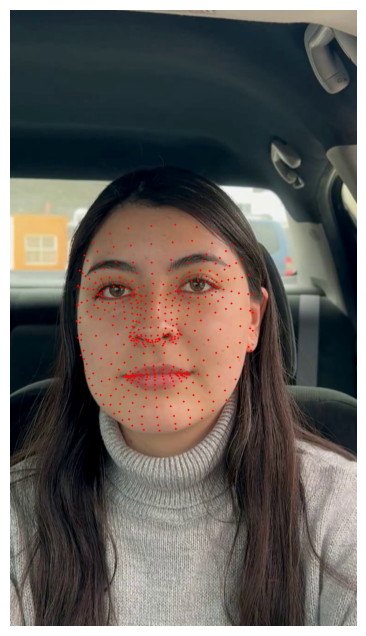

In [25]:
# Inicializar el modelo FaceMesh de MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Función para procesar un fotograma de video y extraer landmarks faciales
def extract_landmarks_video(frame):
    # Convertir el fotograma a RGB (MediaPipe requiere entradas RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Procesar el fotograma
    results = face_mesh.process(frame_rgb)
    # Extraer landmarks del rostro detectado
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]  # Tomamos solo el primer rostro detectado
        landmarks = [(lm.x, lm.y) for lm in face_landmarks.landmark]
        return landmarks
    else:
        return None

# Cargar el video 
video_path = "VideosSegmentados/frente/SCARLETT_frente_9.mp4" 
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("No se pudo abrir el video")
else:
    print("Video cargado exitosamente")

# Leer un fotograma específico del video
frame_number = 100 
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

if ret:
    # Extraer landmarks del fotograma
    landmarks = extract_landmarks_video(frame)

    # Dibujar los landmarks en el fotograma
    if landmarks:
        for landmark in landmarks:
            x = int(landmark[0] * frame.shape[1])
            y = int(landmark[1] * frame.shape[0])
            cv2.circle(frame, (x, y), 2, (0, 0, 255), -1)

    # Mostrar la imagen con los landmarks 
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print(f"No se pudo leer el fotograma {frame_number} del video")

# Liberar recursos
cap.release()

### <font color='purple'> **3.2 Fotogramas en cada categoría del conjunto de datos completo** </font>

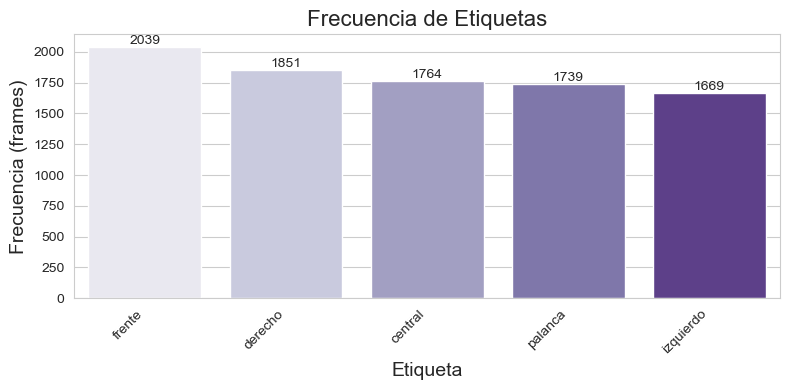

In [73]:
label_frequencies = df_all_data_landmarks['label'].value_counts()

# Establece el estilo de Seaborn
sns.set_style("whitegrid")

# Define una paleta de colores en tonos morados
purple_palette = sns.color_palette("Purples", len(label_frequencies))

# Crea la gráfica
plt.figure(figsize=(8, 4))
barplot = sns.barplot(x=label_frequencies.index, y=label_frequencies.values, palette=purple_palette)

# Añade título y etiquetas
plt.title('Frecuencia de Etiquetas', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Frecuencia (frames)', fontsize=14)

# Rotación de etiquetas en el eje x para mayor legibilidad
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Añade etiquetas sobre las barras
for index, value in enumerate(label_frequencies):
    barplot.text(index, value, str(value), ha='center', va='bottom')

# Muestra la gráfica
plt.tight_layout()
plt.show()

### <font color='purple'> **3.3 Fotogramas en cada categoría del conjunto de datos filtrados** </font>

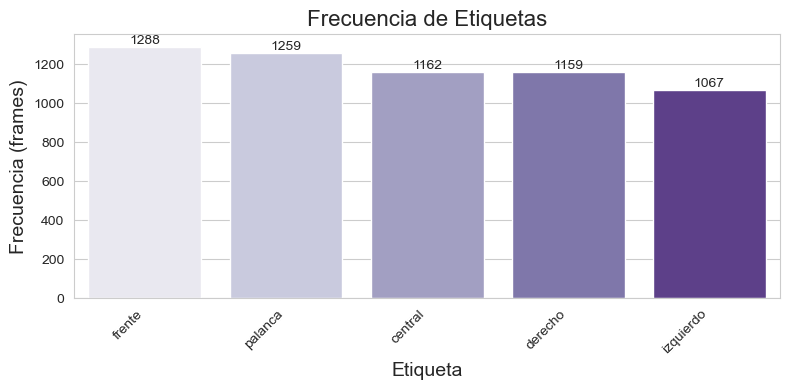

In [74]:
label_frequencies = df_filter_data_landmarks['label'].value_counts()

# Establece el estilo de Seaborn
sns.set_style("whitegrid")

# Define una paleta de colores en tonos morados
purple_palette = sns.color_palette("Purples", len(label_frequencies))

# Crea la gráfica
plt.figure(figsize=(8, 4))
barplot = sns.barplot(x=label_frequencies.index, y=label_frequencies.values, palette=purple_palette)

# Añade título y etiquetas
plt.title('Frecuencia de Etiquetas', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Frecuencia (frames)', fontsize=14)

# Rotación de etiquetas en el eje x para mayor legibilidad
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Añade etiquetas sobre las barras
for index, value in enumerate(label_frequencies):
    barplot.text(index, value, str(value), ha='center', va='bottom')

# Muestra la gráfica
plt.tight_layout()
plt.show()

## <font color='purple'> **4.- Selección de características** </font>

Dada la alta dimensionalidad de los datos, en esta sección llevaremos a cabo la selección de características utilizando la técnica de Ganancia de Información.

### <font color='purple'> **4.1 Dataset completo** </font>

In [28]:
X_all = df_all_data_landmarks.drop(['label', 'filename'], axis=1)
y_all = df_all_data_landmarks['label']

In [41]:
X_new_all = mutual_info_classif(X_all, y_all)
feat_imp_all = pd.Series(X_new_all, df_all_data_landmarks.columns[1:-1])
#Observamos las features con valores mayores a 0.98
feat_imp_sorted_all = feat_imp_all[feat_imp_all > 0.98].sort_values(ascending=False)
display(feat_imp_sorted_all)

z_129    1.014898
z_448    1.002078
z_264    1.002043
z_340    1.000746
z_346    1.000193
z_265    0.999419
z_142    0.999202
z_254    0.998244
z_203    0.998205
z_261    0.995509
z_36     0.990482
z_229    0.988949
z_390    0.988823
z_467    0.988308
z_339    0.987575
z_101    0.985586
z_345    0.984637
z_466    0.984436
z_445    0.984356
z_342    0.983302
z_373    0.982857
z_371    0.982088
dtype: float64

In [80]:
X_all_selected = df_all_data_landmarks[feat_imp_sorted_all.index]
df_all_selected = pd.concat([df_all_data_landmarks['filename'], X_all_selected, y_all], axis=1)
# Guardar el DataFrame como un archivo CSV
df_all_selected.to_csv('df_all_selected.csv', index=False)

### <font color='purple'> **4.2 Dataset filtrado** </font>

In [49]:
X_filter = df_filter_data_landmarks.drop(['label', 'filename'], axis=1)
y_filter = df_filter_data_landmarks['label']

In [59]:
X_new_filter = mutual_info_classif(X_filter, y_filter)
feat_imp_filter = pd.Series(X_new_filter, df_filter_data_landmarks.columns[1:-1])
#Observamos las features con valores mayores a 1.38
feat_imp_sorted_filter = feat_imp_filter[feat_imp_filter > 1.38].sort_values(ascending=False)
display(feat_imp_sorted_filter)

x_213    1.443857
x_147    1.417627
x_111    1.408891
x_187    1.408099
x_35     1.406134
z_229    1.399256
x_208    1.398552
x_181    1.397211
z_117    1.397009
z_147    1.396736
x_192    1.393450
x_29     1.392713
x_156    1.390772
x_142    1.387764
x_144    1.387132
x_89     1.386506
x_180    1.384936
z_371    1.384487
x_171    1.383679
x_129    1.381819
dtype: float64

In [78]:
X_filter_selected = df_filter_data_landmarks[feat_imp_sorted_filter.index]
df_filter_selected = pd.concat([df_filter_data_landmarks['filename'], X_filter_selected, y_filter], axis=1)
# Guardar el DataFrame como un archivo CSV
df_filter_selected.to_csv('df_filter_selected.csv', index=False)

## <font color='purple'> **5.- Construcción y evaluación de los modelos** </font>

En esta sección entrenaremos cuatro modelos para detectar el punto de atención visual al que mira el conductor. Estos modelos seran evaluados utilizando validación cruzada. Se decidió utilizar validación cruzada con Stratified Shuffle Split debido al desbalance en las clases. Los algoritmos de inferencia utilizados son los siguientes:

+ Logistic Regression
+ Random Forest
+ Gradient Boosting
+ Support Vector Machines

Finalmente se analizarán los videos clasificados incorrectamente (falsos positivos y falsos negativos).

### <font color='purple'> **5.1 Definición de funciones** </font>

In [83]:
def validation_predict(model, df, num_folds):

    # Se divide el conjunto de datos en variables independientes y variable dependiente
    X = df.drop('label','filename', axis=1)
    y = df['label']
    
    # Se crea un objeto StratifiedShuffleSplit para dividir los datos originales en folds estratificados
    sss = StratifiedShuffleSplit(n_splits=num_folds, test_size=1/num_folds, random_state=42)
        
    # Se inicializa una lista para almacenar las predicciones de cada fold
    predictions = []
    # Se inicializa una lista para almacenar las etiquetas originales
    labels = []
    indexes = []

    # Realiza la validación cruzada y entrena el modelo en cada fold
    for train_index, test_index in sss.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
         
        if isinstance(model, SVC):
            # Convertir la matriz dispersa a matriz densa antes de ajustar el modelo
            X_train = check_array(X_train, accept_sparse='csr', force_all_finite=False)
            # Ajustar el modelo sin feature_names
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train)

        # Se realizan las predicciones en el conjunto de prueba (datos originales) de este fold
        fold_predictions = model.predict(X_test)

        # Se almacenan las predicciones y etiquetas de cada fold en las listas
        predictions.extend(fold_predictions)
        labels.extend(y_test)
        indexes.extend(test_index)
    
    
    df_predictions = pd.Series(predictions)
    df_labels = pd.Series(labels)
    df_indexes = pd.Series(indexes)
    
    # Se regresan los datos originales con los datos predichos durante la validación cruzada
    return df_labels, df_predictions, df_indexes

In [66]:
def cross_validation_classification_models(df, num_folds):
    
    models = {        
        'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=24),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
        'SVM': SVC(kernel='linear', decision_function_shape='ovr')
    }
    
    predictions = {} # Diccionario para almacenar las predicciones
    
    # Evaluamos el rendimiento de cada modelo
    for model_name, model in models.items():
        
        # Utilizamos cross_val_predict para obtener las predicciones
        y, predicted, indexes = validation_predict(model, df, num_folds)
        
        # Calcula y muestra las métricas
        print("Resultados de validación cruzada para {}:".format(model.__class__.__name__))
        print("Exactitud:", accuracy_score(y, predicted))
        print("Reporte de clasificación:")
        print(classification_report(y, predicted))

        # Calcula y muestra la matriz de confusión como una imagen
        conf_mat = confusion_matrix(y, predicted)
        plt.figure(figsize=(3, 3))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Purples", cbar=False)
        plt.title("Matriz de Confusión")
        plt.xlabel("Predicción")
        plt.ylabel("Valor Real")
        plt.show()
        print()
        
        
        # Almacenamos las métricas en el diccionario
        predictions[model_name] = {
            'index': indexes,
            'real': y,
            'predicted': predicted
        }
        
    return predictions

In [124]:
def reproducir_video(video_path):
    cap = cv2.VideoCapture(video_path)

    # Obtener el ancho y alto del video para redimensionar la ventana
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Definir el nuevo tamaño de la ventana
    new_width = int(width * 0.5)  # Reducir el ancho a la mitad
    new_height = int(height * 0.5)  # Reducir la altura a la mitad

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            # Redimensionar el frame
            frame = cv2.resize(frame, (new_width, new_height))

            cv2.imshow('Video', frame)
            key = cv2.waitKey(25)
            
            # Salir si se presiona la tecla 'q'
            if key & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

### <font color='purple'> **5.2 Dataset completo** </font>

In [ ]:
# Leer el archivo CSV en un DataFrame
#df_all_selected = pd.read_csv('df_all_selected.csv')

Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.8013230429988975
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.75      0.76      0.76      1770
     derecho       0.76      0.78      0.77      1850
      frente       0.70      0.95      0.81      2040
   izquierdo       1.00      0.74      0.85      1670
     palanca       0.96      0.74      0.83      1740

    accuracy                           0.80      9070
   macro avg       0.83      0.80      0.80      9070
weighted avg       0.83      0.80      0.80      9070



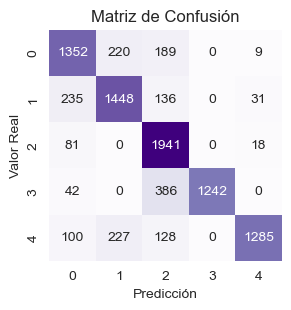


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.9140022050716649
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.89      0.86      0.87      1770
     derecho       0.87      0.92      0.89      1850
      frente       0.92      0.95      0.93      2040
   izquierdo       0.98      0.96      0.97      1670
     palanca       0.93      0.88      0.90      1740

    accuracy                           0.91      9070
   macro avg       0.92      0.91      0.91      9070
weighted avg       0.91      0.91      0.91      9070



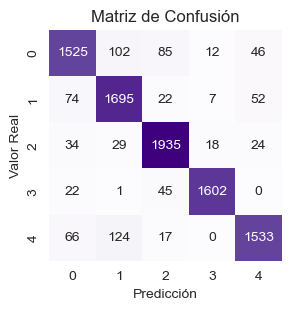


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.8891951488423374
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.84      0.84      0.84      1770
     derecho       0.85      0.86      0.85      1850
      frente       0.90      0.94      0.92      2040
   izquierdo       0.97      0.94      0.96      1670
     palanca       0.90      0.86      0.88      1740

    accuracy                           0.89      9070
   macro avg       0.89      0.89      0.89      9070
weighted avg       0.89      0.89      0.89      9070



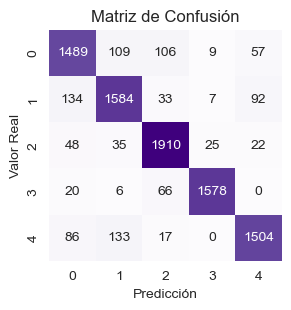


Resultados de validación cruzada para SVC:
Exactitud: 0.7694597574421169
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.58      0.81      0.68      1770
     derecho       0.83      0.70      0.76      1850
      frente       0.74      0.94      0.83      2040
   izquierdo       1.00      0.76      0.87      1670
     palanca       0.89      0.60      0.72      1740

    accuracy                           0.77      9070
   macro avg       0.81      0.76      0.77      9070
weighted avg       0.80      0.77      0.77      9070



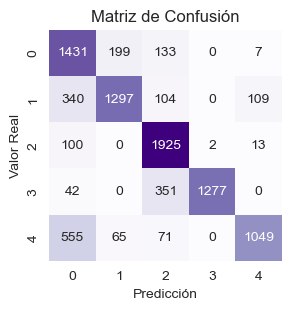

In [76]:
predictions_all = cross_validation_classification_models(df_all_selected, 10)

**Observaciones:** 

En las matrices de confusión de SVM (con una exactitud de 0.77) y Regresión Logística (con una exactitud de 0.80), se observa una tendencia de confusión entre las clases "central" y "derecho", así como entre las clases "frente" e "izquierdo". Además, en la matriz de confusión de SVM, la clase "palanca" tiende a confundirse con la clase "central".

El modelo Gradient Boosting obtuvo el segundo lugar en cuanto a las métricas alcanzadas, logrando una exactitud del 0.89, mientras que Random Forest exhibe el mejor rendimiento, con una exactitud de 0.91. En su matriz de confusión, se aprecia un patrón similar al de Gradient Boosting, pero con menos falsos positivos. Se destaca que en ambos modelos las instancias de "central" suelen confundirse con "derecho" y "frente", y que "palanca" suele confundirse con "central" y "derecho".

#### <font color='purple'> **5.2.1 Visualización de instancias mal clasificadas** </font>

In [101]:
# Obtener los datos de predicción del modelo Random Forest
prediction_data = predictions_all['Random Forest']

# Crear un DataFrame con las predicciones del modelo Random Forest
df_predictions = pd.DataFrame({
    'index': prediction_data['index'].tolist(),
    'actual': prediction_data['real'].tolist(),
    'predicted': prediction_data['predicted'].tolist()
})

df_predictions = df_predictions.sort_values(by='index')
df_predictions = df_predictions.drop_duplicates(subset='index')

# Identificar instancias donde la predicción es incorrecta
df_errors = df_predictions[df_predictions['actual'] != df_predictions['predicted']]

# Establecer la columna "index" como los índices del DataFrame
df_errors.set_index('index', inplace=True)

# Mostrar las instancias originales donde la predicción es incorrecta
df_missclassified_all = df_all_selected.loc[df_errors.index]

# Fusionar df_missclassified con df_errors para agregar la columna "predicted"
df_missclassified_all = df_missclassified_all.merge(df_errors['predicted'], left_index=True, right_index=True)

# Mostrar las instancias mal clasificadas con las columnas "predicted" y "filename"
display(df_missclassified_all)

,filename,z_129,z_448,z_264,z_340,z_346,z_265,z_142,z_254,z_203,...,z_339,z_101,z_345,z_466,z_445,z_342,z_373,z_371,label,predicted
index,,,,,,,,,,,,,,,,,,,,,
0,ANDRES_central_1.mp4,-0.003009,0.000782,0.055840,0.010276,-0.000780,0.017032,0.000941,-0.005610,0.001056,...,-0.002094,0.015454,0.020247,0.000663,-0.007655,0.001529,-0.003298,-0.020465,central,derecho
4,ANDRES_central_1.mp4,0.002632,-0.014113,0.032632,-0.007542,-0.017507,-0.000702,0.008068,-0.017648,0.008171,...,-0.015611,0.026499,-0.000450,-0.012519,-0.021221,-0.013704,-0.014959,-0.027446,central,derecho
27,ANDRES_central_1.mp4,0.004935,-0.019932,0.022502,-0.014640,-0.023580,-0.008287,0.010764,-0.022286,0.011128,...,-0.020901,0.029981,-0.008430,-0.018768,-0.027354,-0.020603,-0.019953,-0.028894,central,palanca
32,ANDRES_central_1.mp4,-0.001380,-0.002400,0.050541,0.006283,-0.004505,0.013285,0.003503,-0.007662,0.002942,...,-0.004533,0.019516,0.015286,-0.001956,-0.009707,-0.001328,-0.005462,-0.021751,central,derecho
34,ANDRES_central_1.mp4,-0.004226,0.004393,0.062068,0.014277,0.002207,0.022388,0.000970,-0.001872,-0.000515,...,0.002016,0.016711,0.024041,0.005464,-0.001446,0.007245,0.000624,-0.020336,central,derecho
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,RACHEL_palanca_6.mp4,0.007921,-0.022401,-0.008966,-0.022950,-0.026512,-0.019111,0.012696,-0.020409,0.012230,...,-0.021268,0.026289,-0.023091,-0.019582,-0.023913,-0.022272,-0.018936,-0.020921,palanca,derecho
8355,RACHEL_palanca_6.mp4,0.007044,-0.020790,-0.006058,-0.020948,-0.024605,-0.017064,0.011696,-0.019173,0.011235,...,-0.019783,0.024925,-0.020635,-0.018260,-0.022502,-0.020666,-0.017779,-0.020136,palanca,derecho
8356,RACHEL_palanca_6.mp4,0.006351,-0.018650,-0.002362,-0.018183,-0.022164,-0.014314,0.010837,-0.017527,0.010333,...,-0.017889,0.023631,-0.017390,-0.016298,-0.020459,-0.018397,-0.016115,-0.019257,palanca,derecho


In [102]:
# Guardar el DataFrame como un archivo CSV
df_missclassified_all.to_csv('df_missclassified_all.csv', index=False)

##### <font color='purple'> **5.2.1.1 Retrovisor Central** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como central cuando correspondía a derecho.

In [197]:
central_all = df_missclassified_all[df_missclassified_all['predicted'] == 'central']
video_label = central_all.iloc[0]['label']
video_filename = central_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", central_all.iloc[0]['predicted'])

Correspondía a la clase:  derecho
Fue clasificado como:  central


**Nota:** Mira al retrovisor derecho y al frente.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como derecho cuando correspondía a central.

In [199]:
central_all = df_missclassified_all[df_missclassified_all['label'] == 'central']
video_label = central_all.iloc[0]['label']
video_filename = central_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", central_all.iloc[0]['predicted'])

Correspondía a la clase:  central
Fue clasificado como:  derecho


**Nota:** Mira al retrovisor central y al frente.

##### <font color='purple'> **5.2.1.2 Retrovisor Derecho** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como derecho cuando correspondía a palanca.

In [200]:
derecho_all = df_missclassified_all[df_missclassified_all['predicted'] == 'derecho']
video_label = derecho_all.iloc[-1]['label']
video_filename = derecho_all.iloc[-1]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", derecho_all.iloc[0]['predicted'])

Correspondía a la clase:  palanca
Fue clasificado como:  derecho


**Nota:** Inicia con la transición de mirar al retrovisor derecho y luego a la palanca.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como palanca cuando correspondía a derecho.

In [201]:
derecho_all = df_missclassified_all[df_missclassified_all['label'] == 'derecho']
video_label = derecho_all.iloc[0]['label']
video_filename = derecho_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", derecho_all.iloc[0]['predicted'])

Correspondía a la clase:  derecho
Fue clasificado como:  palanca


**Nota:** Mira al retrovisor derecho y al frente.

##### <font color='purple'> **5.2.1.3 Retrovisor Izquierdo** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como izquierdo cuando correspondía a central.

In [202]:
izquierdo_all = df_missclassified_all[df_missclassified_all['predicted'] == 'izquierdo']
video_label = izquierdo_all.iloc[0]['label']
video_filename = izquierdo_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", izquierdo_all.iloc[0]['predicted'])

Correspondía a la clase:  central
Fue clasificado como:  izquierdo


**Nota:** Mira al retrovisor central mientras mueve la cabeza.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como frente cuando correspondía a izquierdo.

In [203]:
izquierdo_all = df_missclassified_all[df_missclassified_all['label'] == 'izquierdo']
video_label = izquierdo_all.iloc[0]['label']
video_filename = izquierdo_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", izquierdo_all.iloc[0]['predicted'])

Correspondía a la clase:  izquierdo
Fue clasificado como:  frente


**Nota:** Mira al retrovisor izquierdo y al frente.

##### <font color='purple'> **5.2.1.4 Frente** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como frente cuando correspondía a central.

In [206]:
frente_all = df_missclassified_all[df_missclassified_all['predicted'] == 'frente']
video_label = frente_all.iloc[0]['label']
video_filename = frente_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", frente_all.iloc[0]['predicted'])

Correspondía a la clase:  central
Fue clasificado como:  frente


**Nota:** Mira al retrovisor central y al frente.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como izquierdo cuando correspondía a frente.

In [207]:
frente_all = df_missclassified_all[df_missclassified_all['label'] == 'frente']
video_label = frente_all.iloc[0]['label']
video_filename = frente_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", frente_all.iloc[0]['predicted'])

Correspondía a la clase:  frente
Fue clasificado como:  izquierdo


**Nota** En este video siempre mira al frente.

##### <font color='purple'> **5.2.1.5 Palanca** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como palanca cuando correspondía a central.

In [194]:
palanca_all = df_missclassified_all[df_missclassified_all['predicted'] == 'palanca']
video_label = palanca_all.iloc[0]['label']
video_filename = palanca_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", palanca_all.iloc[0]['predicted'])

Correspondía a la clase:  central
Fue clasificado como:  palanca


**Nota:** Mira al retrovisor central y volante pero no a la palanca.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como frente cuando correspondía a palanca.

In [196]:
palanca_all = df_missclassified_all[df_missclassified_all['label'] == 'palanca']
video_label = palanca_all.iloc[0]['label']
video_filename = palanca_all.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", palanca_all.iloc[0]['predicted'])

Correspondía a la clase:  palanca
Fue clasificado como:  frente


**Nota:** Mira a la palanca y al frente.

#### <font color='purple'> **5.2.2 Análisis de instancias mal clasificadas** </font>

En los videos donde se presentaban instancias mal clasificadas, los conductores dirigían su atención a varios puntos incluso cuando el video se etiquetaba como uno solo. Esto resultaba en fotogramas que correspondían a clases diferentes dentro del mismo video. Por consiguiente, parece que las instancias mal clasificadas se deben más a errores de etiquetado que a errores del modelo.

### <font color='purple'> **5.3 Dataset filtrado** </font>

In [ ]:
# Leer el archivo CSV en un DataFrame
#df_filter_selected = pd.read_csv('df_filter_selected.csv')

Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.9567340067340068
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.97      0.97      0.97      1160
     derecho       0.96      0.97      0.97      1160
      frente       0.89      0.99      0.94      1290
   izquierdo       1.00      0.98      0.99      1070
     palanca       0.98      0.89      0.93      1260

    accuracy                           0.96      5940
   macro avg       0.96      0.96      0.96      5940
weighted avg       0.96      0.96      0.96      5940



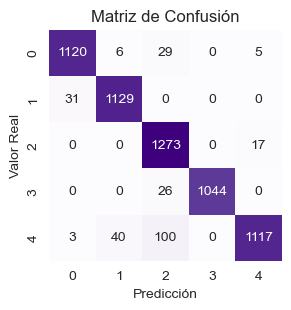


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.9939393939393939
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.99      0.99      0.99      1160
     derecho       0.99      0.99      0.99      1160
      frente       0.99      1.00      0.99      1290
   izquierdo       1.00      1.00      1.00      1070
     palanca       0.99      1.00      0.99      1260

    accuracy                           0.99      5940
   macro avg       0.99      0.99      0.99      5940
weighted avg       0.99      0.99      0.99      5940



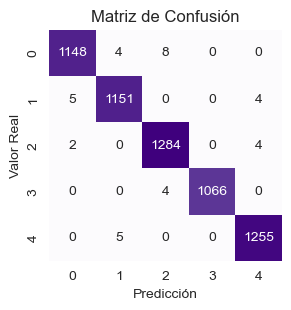


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.9954545454545455
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.99      1.00      0.99      1160
     derecho       0.99      0.99      0.99      1160
      frente       1.00      0.99      1.00      1290
   izquierdo       1.00      1.00      1.00      1070
     palanca       1.00      0.99      0.99      1260

    accuracy                           1.00      5940
   macro avg       1.00      1.00      1.00      5940
weighted avg       1.00      1.00      1.00      5940



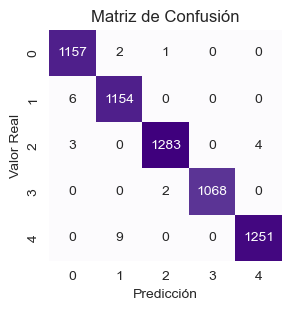


Resultados de validación cruzada para SVC:
Exactitud: 0.8193602693602694
Reporte de clasificación:
              precision    recall  f1-score   support

     central       0.65      0.49      0.56      1160
     derecho       0.96      0.73      0.83      1160
      frente       0.90      0.99      0.94      1290
   izquierdo       1.00      0.99      1.00      1070
     palanca       0.65      0.89      0.75      1260

    accuracy                           0.82      5940
   macro avg       0.83      0.82      0.82      5940
weighted avg       0.83      0.82      0.81      5940



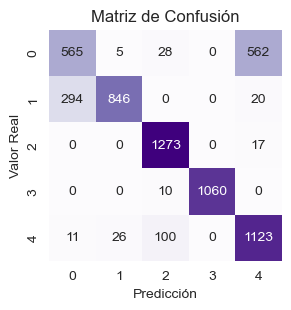

In [75]:
predictions_filter = cross_validation_classification_models(df_filter_selected, 10)

**Observaciones:** 

En la matriz de confusión de SVM (con una exactitud de 0.82), se observa que el modelo tiende a confundir la clase "central" con "palanca", así como la clase "derecho" con "central" y la clase "palanca" con "frente". Por otro lado, en el modelo de Regresión Logística (con una exactitud de 0.96), se evidencia que las instancias pertenecientes a las clases "central", "derecho", "izquierdo" y "palanca" tienden a confundirse con "frente".

El modelo Random Forest obtuvo el segundo lugar en cuanto a las métricas alcanzadas, logrando una exactitud del 0.9939, mientras que Gradient Boosting exhibe el mejor rendimiento, con una exactitud de 0.9954. Estas métricas son muy altas, lo que puede indicar un sobreajuste del modelo.

Aunque Gradient Boosting obtuvo las métricas más altas, su diferencia con Random Forest no es significativa. Dado que Random Forest fue el mejor modelo para los datos completos, optaremos por utilizarlo en nuestro análisis con los datos filtrados, con el fin de observar el impacto de la selección de datos en el desempeño del modelo.


#### <font color='purple'> **5.3.1 Visualización de instancias mal clasificadas** </font>

Aunque el Gradient Boosting fue identificado como el mejor modelo, optaremos por continuar nuestro análisis con el modelo que se desempeñó mejor utilizando el conjunto de datos completo (Random Forest). Esto se hace con el propósito de realizar una comparación imparcial entre los modelos, ya que el enfoque de este notebook se ha centrado en examinar cómo el etiquetado influye en los modelos.

In [105]:
# Obtener los datos de predicción del modelo Random Forest
prediction_data = predictions_filter['Random Forest']

# Crear un DataFrame con las predicciones del modelo Random Forest
df_predictions = pd.DataFrame({
    'index': prediction_data['index'].tolist(),
    'actual': prediction_data['real'].tolist(),
    'predicted': prediction_data['predicted'].tolist()
})

df_predictions = df_predictions.sort_values(by='index')
df_predictions = df_predictions.drop_duplicates(subset='index')

# Identificar instancias donde la predicción es incorrecta
df_errors = df_predictions[df_predictions['actual'] != df_predictions['predicted']]

# Establecer la columna "index" como los índices del DataFrame
df_errors.set_index('index', inplace=True)

# Mostrar las instancias originales donde la predicción es incorrecta
df_missclasified_filter = df_filter_selected.loc[df_errors.index]

# Fusionar df_missclasified con df_errors para agregar la columna "predicted"
df_missclasified_filter = df_missclasified_filter.merge(df_errors['predicted'], left_index=True, right_index=True)

# Mostrar las instancias mal clasificadas con las columnas "predicted" y "filename"
display(df_missclasified_filter)

,filename,x_213,x_147,x_111,x_187,x_35,z_229,x_208,x_181,z_117,...,x_156,x_142,x_144,x_89,x_180,z_371,x_171,x_129,label,predicted
index,,,,,,,,,,,,,,,,,,,,,
220,JESUS_central_6.mp4,0.424132,0.422387,0.432193,0.438322,0.431341,0.015361,0.514703,0.511067,0.019233,...,0.426684,0.491695,0.467442,0.505214,0.512459,-0.002957,0.512442,0.494946,central,frente
221,JESUS_central_6.mp4,0.424118,0.422172,0.431171,0.438299,0.430241,0.016368,0.514266,0.511600,0.020162,...,0.425539,0.490761,0.466076,0.506204,0.513050,-0.002941,0.511727,0.494168,central,frente
223,JESUS_central_6.mp4,0.422058,0.419708,0.428081,0.435271,0.427276,0.016628,0.511702,0.508049,0.021227,...,0.422410,0.488422,0.462611,0.502300,0.509355,-0.003759,0.509738,0.492126,central,frente
227,JESUS_central_6.mp4,0.406876,0.404736,0.412647,0.417840,0.412164,0.024616,0.489596,0.485452,0.030489,...,0.407939,0.467909,0.445153,0.479818,0.486523,-0.007066,0.488308,0.470861,central,frente
230,JESUS_central_6.mp4,0.392531,0.389703,0.394534,0.399973,0.394319,0.031950,0.466167,0.460249,0.039994,...,0.390384,0.443582,0.422393,0.455814,0.461182,-0.011767,0.465848,0.446417,central,frente
233,JESUS_central_6.mp4,0.376144,0.372324,0.375250,0.379702,0.375380,0.039054,0.443541,0.434653,0.049292,...,0.371585,0.417543,0.398486,0.430153,0.435138,-0.016235,0.444391,0.419905,central,frente
567,RACHEL_central_7.mp4,0.482842,0.479334,0.479508,0.484277,0.479747,0.029875,0.529586,0.523642,0.038565,...,0.476909,0.510349,0.495414,0.521079,0.523911,-0.013197,0.530412,0.512784,central,derecho
860,RACHEL_central_7.mp4,0.481560,0.478046,0.477968,0.483183,0.478161,0.030025,0.528231,0.522477,0.038641,...,0.475393,0.509334,0.494143,0.520213,0.522876,-0.013317,0.528937,0.511837,central,derecho
1692,RACHEL_derecho_7.mp4,0.481439,0.477946,0.477810,0.483159,0.477942,0.029800,0.528327,0.522509,0.038535,...,0.475091,0.509068,0.493874,0.520194,0.522867,-0.013327,0.529057,0.511533,derecho,central


In [104]:
# Guardar el DataFrame como un archivo CSV
#df_missclasified_filter.to_csv('GBdf_missclasified_filter.csv', index=False)

In [106]:
# Guardar el DataFrame como un archivo CSV
df_missclasified_filter.to_csv('df_missclasified_filter.csv', index=False)

##### <font color='purple'> **5.3.1.1 Retrovisor Central** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como central cuando correspondía a derecho.

In [209]:
central_filter = df_missclasified_filter[df_missclasified_filter['predicted'] == 'central']
video_label = central_filter.iloc[0]['label']
video_filename = central_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", central_filter.iloc[0]['predicted'])

Correspondía a la clase:  derecho
Fue clasificado como:  central


**Nota:** El video inicia mirando al retrovisor central y después transiciona al retrovisor derecho.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como frente cuando correspondía a central.

In [210]:
central_filter = df_missclasified_filter[df_missclasified_filter['label'] == 'central']
video_label = central_filter.iloc[0]['label']
video_filename = central_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", central_filter.iloc[0]['predicted'])

Correspondía a la clase:  central
Fue clasificado como:  frente


**Nota:** El video inicia mirando al frente y después transiciona al retrovisor central.

##### <font color='purple'> **5.3.1.2 Retrovisor Derecho** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como derecho cuando correspondía a palanca.

In [212]:
derecho_filter = df_missclasified_filter[df_missclasified_filter['predicted'] == 'derecho']
video_label = derecho_filter.iloc[-1]['label']
video_filename = derecho_filter.iloc[-1]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", derecho_filter.iloc[0]['predicted'])

Correspondía a la clase:  palanca
Fue clasificado como:  derecho


**Nota:** El video inicia mirando al retrovisor derecho y después transiciona a la palanca.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como central cuando correspondía a derecho.

In [214]:
derecho_filter = df_missclasified_filter[df_missclasified_filter['label'] == 'derecho']
video_label = derecho_filter.iloc[0]['label']
video_filename = derecho_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", derecho_filter.iloc[0]['predicted'])

Correspondía a la clase:  derecho
Fue clasificado como:  central


**Nota:** El video inicia mirando al retrovisor central y después transiciona al retrovisor derecho.

##### <font color='purple'> **5.3.1.3 Retrovisor Izquierdo** </font>

<font color='purple'> **Falso positivo:** </font> No hubo instancias mal clasificadas.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como frente cuando correspondía a izquierdo.

In [216]:
izquierdo_filter = df_missclasified_filter[df_missclasified_filter['label'] == 'izquierdo']
video_label = izquierdo_filter.iloc[0]['label']
video_filename = izquierdo_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", izquierdo_filter.iloc[0]['predicted'])

Correspondía a la clase:  izquierdo
Fue clasificado como:  frente


**Nota:** El video inicia mirando al frente y después transiciona al retrovisor izquierdo.

##### <font color='purple'> **5.3.1.4 Frente** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como frente cuando correspondía a central.

In [217]:
frente_filter = df_missclasified_filter[df_missclasified_filter['predicted'] == 'frente']
video_label = frente_filter.iloc[0]['label']
video_filename = frente_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", frente_filter.iloc[0]['predicted'])

Correspondía a la clase:  central
Fue clasificado como:  frente


**Nota:** El video inicia mirando al frente y después transiciona al retrovisor central.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como palanca cuando correspondía a central.

In [219]:
frente_filter = df_missclasified_filter[df_missclasified_filter['label'] == 'frente']
video_label = frente_filter.iloc[0]['label']
video_filename = frente_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", frente_filter.iloc[0]['predicted'])

Correspondía a la clase:  frente
Fue clasificado como:  palanca


**Nota:** El video inicia mirando a la palanca y después transiciona al frente.

##### <font color='purple'> **5.3.1.5 Palanca** </font>

<font color='purple'> **Falso positivo:** </font> Fue clasificado como palanca cuando correspondía a derecho.

In [221]:
palanca_filter = df_missclasified_filter[df_missclasified_filter['predicted'] == 'palanca']
video_label = palanca_filter.iloc[0]['label']
video_filename = palanca_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", palanca_filter.iloc[0]['predicted'])

Correspondía a la clase:  derecho
Fue clasificado como:  palanca


**Nota:** El video inicia mirando al retrovisor central y después transiciona al retrovisor derecho.

<font color='purple'> **Falso negativo:** </font> Fue clasificado como derecho cuando correspondía a palanca.

In [222]:
palanca_filter = df_missclasified_filter[df_missclasified_filter['label'] == 'palanca']
video_label = palanca_filter.iloc[0]['label']
video_filename = palanca_filter.iloc[0]['filename']

# Especifica la ruta al archivo de video
notebook_directory = "C:/Users/scarl/Desktop/CICESE/Cuatrimestre2/CDSI/Prácticas/Práctica2/VideosSegmentados2/"
video_path = notebook_directory + video_label + "/" + video_filename
reproducir_video(video_path)
print("Correspondía a la clase: ", video_label)
print("Fue clasificado como: ", palanca_filter.iloc[0]['predicted'])

Correspondía a la clase:  palanca
Fue clasificado como:  derecho


**Nota:** El video inicia mirando al retrovisor derecho y después transiciona a la palanca.

#### <font color='purple'> **5.3.2 Análisis de instancias mal clasificadas** </font>

De las 10 instancias observadas, en 9 de ellas se confirma que los conductores comienzan el video mirando la instancia predicha. Esta consistencia sugiere nuevamente que las instancias mal clasificadas probablemente se deben a una etiquetación incorrecta de los datos en lugar de alguna dificultad del modelo para clasificarlas.

## <font color='purple'> **6.- Validación externa** </font>

En esta sección, reentrenaremos los mejores clasificadores obtenidos anteriormente utilizando todos los datos disponibles. Posteriormente, evaluaremos un video que no ha sido visto por los modelos y analizaremos el rendimiento de los clasificadores finales en un entorno de video en tiempo real para determinar su eficacia.

### <font color='purple'> **6.1 Reentrenamiento del mejor clasificador** </font>

#### <font color='purple'> **6.1.1 Dataset completo** </font>

In [47]:
df_all_selected = pd.read_csv("df_all_selected.csv")
X_all_selected = df_all_selected.drop(['label', 'filename'], axis=1) 
y_all = df_all_selected['label']

In [48]:
# Random Forest
best_clf_all = RandomForestClassifier(n_estimators=100, random_state=24)
best_clf_all.fit(X_all_selected, y_all)

RandomForestClassifier(random_state=24)

#### <font color='purple'> **6.1.2 Dataset filtrado** </font>

In [15]:
df_filter_selected = pd.read_csv("df_filter_selected.csv")
X_filter_selected = df_filter_selected.drop(['label', 'filename'], axis=1) 
y_filter = df_filter_selected['label']

In [16]:
# Random Forest
best_clf_filter = RandomForestClassifier(n_estimators=100, random_state=24)
best_clf_filter.fit(X_filter_selected, y_filter)

RandomForestClassifier(random_state=24)

### <font color='purple'> **6.2 Validación del clasificador en un video nuevo** </font>

#### <font color='purple'> **6.2.1 Función para extraer landmarks de un frame de video** </font>

In [56]:
# Función para extraer landmarks de un frame de video
def extract_landmarks_frame(frame):
    mp_face_mesh = mp.solutions.face_mesh
    mp_drawing = mp.solutions.drawing_utils

    # Define las especificaciones de dibujo para los landmarks (puntos)
    draw_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=0.5, circle_radius=0.5)

    # Inicializa el modelo de detección de face mesh
    with mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        # Convierte el frame de BGR a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detección de face mesh
        results = face_mesh.process(frame_rgb)

        # Inicializa una lista para almacenar los landmarks
        landmarks_flat = []

        # Dibuja los puntos de landmark si se detectan rostros
        if results.multi_face_landmarks:

            for face_landmarks in results.multi_face_landmarks:
                landmark_dict = {}  # Diccionario para almacenar las coordenadas de los landmarks
                for i, landmark in enumerate(face_landmarks.landmark):
                    landmark_dict[f'x_{i}'] = landmark.x
                    landmark_dict[f'y_{i}'] = landmark.y
                    landmark_dict[f'z_{i}'] = landmark.z
                landmarks_flat.append(landmark_dict)  # Agregar el diccionario de landmarks a la lista
                
        return landmarks_flat

#### <font color='purple'> **6.2.2 Dataset completo** </font>

In [57]:
# Inicializar el detector de rostros. Usaremos el modelo de detección precisa en este ejemplo.
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

video_path = 'MARCOS.mp4'  # Reemplaza esto con la ruta a tu video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error al abrir el video")
else:
    while True:
        success, image = cap.read()
        if not success:
            print("Fin del video.")  # Indica el fin del video y sale del bucle
            break

        # Extrae los landmarks del frame actual
        landmarks_data = extract_landmarks_frame(image)

        # Si se detectan landmarks
        if landmarks_data:
            
            # Convertir la lista de diccionarios en un DataFrame
            landmarks_df = pd.DataFrame(landmarks_data)

            # Filtra los landmarks para que solo contenga las columnas de X_all_selected
            landmarks_filtered = landmarks_df.filter(items=X_all_selected.columns)

            # Realiza la predicción
            prediction = best_clf_all.predict(landmarks_filtered)

            # Muestra la predicción en el frame
            cv2.putText(image, "Prediccion: " + str(prediction), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        else:
            # Si no se detectan landmarks, muestra un mensaje
            cv2.putText(image, "No se detectaron landmarks", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Redimensionar la imagen a la mitad
        height, width, _ = image.shape
        new_width = width // 3
        new_height = height // 3
        resized_image = cv2.resize(image, (new_width, new_height))

        cv2.imshow('Face Detection in Video', resized_image)

        # Espera 1 milisegundo entre cada iteración
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Permite la opción de terminar prematuramente con la tecla 'q'
            break

cap.release()
cv2.destroyAllWindows()

**Observación:** El modelo logró clasificar con precisión todos los puntos de atención visual.

#### <font color='purple'> **6.2.3 Dataset filtrado** </font>

In [58]:
# Inicializar el detector de rostros. Usaremos el modelo de detección precisa en este ejemplo.
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

video_path = 'MARCOS.mp4'  # Reemplaza esto con la ruta a tu video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error al abrir el video")
else:
    while True:
        success, image = cap.read()
        if not success:
            print("Fin del video.")  # Indica el fin del video y sale del bucle
            break

        # Extrae los landmarks del frame actual
        landmarks_data = extract_landmarks_frame(image)

        # Si se detectan landmarks
        if landmarks_data:
            
            # Convertir la lista de diccionarios en un DataFrame
            landmarks_df = pd.DataFrame(landmarks_data)

            # Filtra los landmarks para que solo contenga las columnas de X_all_selected
            landmarks_filtered = landmarks_df.filter(items=X_filter_selected.columns)

            # Realiza la predicción
            prediction = best_clf_filter.predict(landmarks_filtered)

            # Muestra la predicción en el frame
            cv2.putText(image, "Prediccion: " + str(prediction), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        else:
            # Si no se detectan landmarks, muestra un mensaje
            cv2.putText(image, "No se detectaron landmarks", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Redimensionar la imagen a la mitad
        height, width, _ = image.shape
        new_width = width // 3
        new_height = height // 3
        resized_image = cv2.resize(image, (new_width, new_height))

        cv2.imshow('Face Detection in Video', resized_image)

        # Espera 1 milisegundo entre cada iteración
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Permite la opción de terminar prematuramente con la tecla 'q'
            break

cap.release()
cv2.destroyAllWindows()

**Observación:** El modelo logró clasificar correctamente 4 de los 5 puntos de atención visual. Sin embargo, cuando el conductor miraba hacia la palanca, el modelo presentaba cierta inconsistencia al clasificar algunos fotogramas como "palanca" y otros como "frente".

### <font color='purple'> **6.3 Validación del clasificador en tiempo real** </font>

#### <font color='purple'> **6.3.1 Función para extraer landmarks en vivo** </font>

In [25]:
def extract_landmarks_live(frame):
    # Convertir el fotograma a RGB (MediaPipe requiere entradas RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Procesar el fotograma
    results = face_mesh.process(frame_rgb)
    # Extraer landmarks del rostro detectado
    landmarks_flat = []
    if results.multi_face_landmarks:

        for face_landmarks in results.multi_face_landmarks:
            landmark_dict = {}  # Diccionario para almacenar las coordenadas de los landmarks
            for i, landmark in enumerate(face_landmarks.landmark):
                landmark_dict[f'x_{i}'] = landmark.x
                landmark_dict[f'y_{i}'] = landmark.y
                landmark_dict[f'z_{i}'] = landmark.z
            landmarks_flat.append(landmark_dict)  # Agregar el diccionario de landmarks a la lista
            
    # Crear un DataFrame con las coordenadas de los landmarks
    landmarks_df = pd.DataFrame(landmarks_flat)
    return landmarks_df

#### <font color='purple'> **6.3.2 Dataset completo** </font>

In [52]:
cap = cv2.VideoCapture(0)  

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

# Define las especificaciones de dibujo para los landmarks (puntos)
draw_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=0.5, circle_radius=0.5)

with mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        # Convierte la imagen de BGR a RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Detección de face mesh
        results = face_mesh.process(image_rgb)

        # Dibuja los puntos de landmark
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for landmark in face_landmarks.landmark:
                    x = int(landmark.x * image.shape[1])
                    y = int(landmark.y * image.shape[0])
                    cv2.circle(image, (x, y), 2, (0, 0, 255), -1)
        
        # Extraer landmarks del cuadro actual
        landmarks_data = extract_landmarks_live(image)
        
        # Filtrar landmarks_data para que solo contenga las columnas de X_all_selected
        landmarks_filtered = landmarks_data.filter(items=X_all_selected.columns)
        
  
        # Verificar si landmarks_filtered está vacío
        if not landmarks_filtered.empty:
            # Utilizar los datos filtrados como entrada al modelo y obtener la predicción
            prediction = best_clf_all.predict(landmarks_filtered)
            # Mostrar la predicción en la ventana de la cámara
            cv2.putText(image, "Prediccion: " + str(prediction), (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        else:
            # Mostrar un mensaje indicando que no se detectaron landmarks
            cv2.putText(image, "No se detectaron landmarks", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.putText(image, "Presiona una tecla para terminar", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                
        # Muestra la imagen
        cv2.imshow('Face Mesh Detection', image)
        if cv2.waitKey(1) != -1:  # Si se presiona cualquier tecla, termina la ejecución
            break

cap.release()
cv2.destroyAllWindows()


#### <font color='purple'> **6.3.3 Dataset filtrado** </font>

In [18]:
cap = cv2.VideoCapture(0)  

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

# Define las especificaciones de dibujo para los landmarks (puntos)
draw_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=0.5, circle_radius=0.5)

with mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        # Convierte la imagen de BGR a RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Detección de face mesh
        results = face_mesh.process(image_rgb)

        # Dibuja los puntos de landmark
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for landmark in face_landmarks.landmark:
                    x = int(landmark.x * image.shape[1])
                    y = int(landmark.y * image.shape[0])
                    cv2.circle(image, (x, y), 2, (0, 0, 255), -1)
        
        # Extraer landmarks del cuadro actual
        landmarks_data = extract_landmarks_live(image)
        
        # Filtrar landmarks_data para que solo contenga las columnas de X_all_selected
        landmarks_filtered = landmarks_data.filter(items=X_filter_selected.columns)
        
  
        # Verificar si landmarks_filtered está vacío
        if not landmarks_filtered.empty:
            # Utilizar los datos filtrados como entrada al modelo y obtener la predicción
            prediction = best_clf_filter.predict(landmarks_filtered)
            # Mostrar la predicción en la ventana de la cámara
            cv2.putText(image, "Prediccion: " + str(prediction), (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        else:
            # Mostrar un mensaje indicando que no se detectaron landmarks
            cv2.putText(image, "No se detectaron landmarks", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.putText(image, "Presiona una tecla para terminar", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                
        # Muestra la imagen
        cv2.imshow('Face Mesh Detection', image)
        if cv2.waitKey(1) != -1:  # Si se presiona cualquier tecla, termina la ejecución
            break

cap.release()
cv2.destroyAllWindows()

#### <font color='purple'> **6.3.4 Observaciones del rendimiento** </font>

A primera vista, no se pueden apreciar diferencias significativas en el rendimiento entre los distintos modelos cuando se evalúan en tiempo real. Sin embargo, en general, los modelos tienden a reconocer las cinco clases, aunque en ciertos ángulos del rostro pueden confundirse entre dos clases simultáneamente.

## <font color='purple'> **7.- Conclusión** </font>

Para la elaboración de este Notebook, se llevó a cabo la captura de datos de video que involucraron la grabación de personas "conduciendo" y enfocando su atención en cinco puntos de atención visual (PAV), siendo estos el frente, los retrovisores central, izquierdo y derecho, y la palanca. Posteriormente cada video fue etiquetado con los tiempos de inicio y fin de cada PAV. 

Después, los videos se segmentaron según los tiempos indicados en las etiquetas. Durante este proceso, se identificaron algunas instancias mal etiquetadas y se corrigieron. Además, se observaron videos etiquetados para un solo punto de atención visual, pero en los cuales el conductor miraba varios puntos a la vez. Debido a esto, se optó por dividir el conjunto de datos en dos conjuntos: uno que incluye instancias problemáticas (datos completos) y otro que solo contiene instancias correctamente etiquetadas (datos filtrados).

Posteriormente, se procedió a extraer los landmarks del rostro utilizando la función *face mesh* de la librería MediaPipe, la cual identifica 468 puntos faciales con coordenadas (x, y, z). Dada la alta dimensionalidad de los datos resultantes, se optó por seleccionar únicamente los 20-22 landmarks con mayor Ganancia de Información. Posteriormente, se llevaron a cabo evaluaciones de los modelos mediante validación cruzada con 10 folds. Los algoritmos empleados incluyeron Logistic Regression, Random Forest, Gradient Boosting y Support Vector Machines.

Se observó que el modelo que obtuvo los mejores resultados para el conjunto de datos completos fue Random Forest, alcanzando una exactitud del 0.91. Por otro lado, para los datos filtrados, el modelo que mostró el mejor desempeño fue Gradient Boosting, logrando una exactitud de 0.9954. Sin embargo, para garantizar una comparación justa, se realizó el análisis de errores y la validación externa utilizando el mismo modelo Random Forest. En este caso, la exactitud obtenida con los datos filtrados fue de 0.9939.

En el análisis de las instancias mal clasificadas, se determinó que los errores se originaban principalmente en los puntos de transición al inicio de los videos. Aunque el modelo consideraba estas instancias como errores, al revisar los videos se observó que las predicciones realizadas por el modelo eran correctas, pero la etiqueta asignada era incorrecta. Por lo tanto, un etiquetado adecuado de los datos habría reducido el error evidenciado en las matrices de confusión.

Por otro lado, al llevar a cabo la validación externa con un video nunca antes visto por los modelos, se pudo apreciar que el modelo entrenado con todos los datos disponibles clasificó correctamente todos los puntos de atención visual (PAV). En contraste, el modelo entrenado con los datos filtrados tuvo dificultades para distinguir la clase "palanca", ya que la confundió con la clase "frente".

En resumen, el análisis del desempeño de los modelos con ambos conjuntos de datos subraya la importancia del etiquetado preciso y la diversidad en las clases. Si bien la precisión en el etiquetado influye en el rendimiento, la variedad entre las instancias de la misma clase es crucial para fortalecer la robustez de los modelos. La validación externa con todos los datos disponibles demostró cómo esta diversidad contribuye a una mejor capacidad de generalización del modelo. Por otro lado, los datos filtrados, aunque tenían un etiquetado más preciso, carecían de variedad, lo que resultó en un sobreajuste y una menor eficacia en la clasificación de nuevos datos.